In [1]:
import numpy as np 
import glob
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def plot_image(img, title=None, size=(8,5)):
    plt.figure(figsize=size)
    plt.axis("off")
    
    if title is not None:
        plt.title(title)
        
    if len(img.shape) == 3:
        plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
    else:
        plt.imshow(img, cmap='gray')        

    plt.show()

def read_images(image_dir_list, include_flipped=False):    
    images = []
    
    for img_dir in image_dir_list:         
    
        # get all image files in the current directory
        img_file_list = glob.glob('./training_data/' + img_dir + '/?*.png')
        
        img_counter = 0
        
        for img_file in img_file_list:
            img_counter += 1  
            
            if img_counter % 1 == 0:
                
                img = cv2.imread(img_file)        
                images.append(img)

                if include_flipped:
                    images.append(cv2.flip(img,1))
    
    print('imported {} images'.format(len(images)))  
            
    return images         

In [2]:

def get_hog_features(img, make_vector=False):    
    global pix_per_cell
    
    pix_per_cell = 8
    num_orientations = 9  
    cell_per_block = 2

    features = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                      visualise=False, feature_vector=make_vector)

    return features

def plot_feature_vec(feature_vec):
    plt.bar(np.arange(0, len(feature_vec)), feature_vec)
    plt.show()
    
def normalize(features, init=False):
    global scaler 
    
    if init:         
        # create the scaler for normalization
        scaler = StandardScaler().fit(features)
        
    # apply the scaler 
    scaled_vec = scaler.transform(features)
    
    return scaled_vec
        
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    
def extract_features(images):
    features = []
    
    for img in images:  
        
         # convert image color space    
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) 
        
        # extract histogram features on all color channels
        n_bins = 16    
        hist_feature_vec_0, bins = np.histogram(img[:,:,0], n_bins, (0, 256))
        hist_feature_vec_1, bins = np.histogram(img[:,:,1], n_bins, (0, 256))
        hist_feature_vec_2, bins = np.histogram(img[:,:,2], n_bins, (0, 256))
        
        # extract HOG features on all color channels
        hog_feature_vec_0 = get_hog_features(img[:,:,0], make_vector=True) 
        hog_feature_vec_1 = get_hog_features(img[:,:,1], make_vector=True)
        hog_feature_vec_2 = get_hog_features(img[:,:,2], make_vector=True)
        
        # extract spatial binning features
        img_resized = cv2.resize(img, (16, 16))
        spatial_feature_vec = img_resized.ravel()
        
        feature_vec_combined = np.concatenate((hist_feature_vec_0, hist_feature_vec_1, hist_feature_vec_2, 
                                               hog_feature_vec_0,  hog_feature_vec_1,  hog_feature_vec_2, 
                                               spatial_feature_vec))       

        features.append(feature_vec_combined)
        
    return features


In [29]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle

def calculate_test_accuracy(classifier, features, labels):   
    
    pred = classifier.predict(features)
    num_correct = np.count_nonzero(pred == labels)
    acc = 1.0*num_correct/len(labels)
            
    return acc            

def create_classifier(vehicle_features, non_vehicle_features):

    # create input data from features
    X_raw = np.vstack((vehicle_features, non_vehicle_features))
    X_raw = X_raw.reshape((X_raw.shape[0], X_raw.shape[1]))
    
    # normalize the features
    X = normalize(X_raw, init=True)

    # create output labels: 1=vehicle, 0=non-vehicle
    vehicle_labels = np.ones((len(vehicle_features)))
    non_vehicle_labels = np.zeros((len(non_vehicle_features)))
    y = np.hstack((vehicle_labels, non_vehicle_labels))

    # shuffle the data
    X, y = shuffle(X, y)

    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # train a SVM for classification by performing a grid search in parameter space
    #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 3, 5, 7, 9]} # best until now: {'C': 5, 'kernel': 'rbf'}
    parameters = {'C':[2]}
    #parameters = {'C':[3, 3.5, 4, 4.5, 5]}
    #parameters = {'C':[3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3]}
    
    #svc = svm.SVC(kernel='linear')    
    #classifier = GridSearchCV(svc, parameters)
    
    classifier = RandomForestClassifier(n_estimators =6, random_state=42)
    
    print('begin training ...')
    
    classifier.fit(X_train, y_train)  
    
    print('finished training!')    
    #print('best parameters: {}'.format(classifier.best_params_)) # {'C': 5, 'kernel': 'rbf'}
    
    acc = calculate_test_accuracy(classifier, X_test, y_test)
    
    print('test accuracy = {:.3f}'.format(acc))
    
    # save the classifier
    with open('classifier.pkl', 'wb') as fid:
        pickle.dump(classifier, fid)  
        print('saved classifier')
    
    return classifier


In [30]:
train_classifier = True

if train_classifier: # train a new classifier 

#     # read vehicle images
#     vehicle_images = read_images(['vehicles/GTI_Far', 'vehicles/GTI_Left', 'vehicles/GTI_MiddleClose', 
#                     'vehicles/GTI_Right', 'vehicles/KITTI_extracted'])#, 'vehicles/udacity'])
    
#     # read non-vehicle images
#     non_vehicle_images = read_images(['non-vehicles/GTI', 'non-vehicles/Extras'])
    
#     # extract features from images
#     vehicle_features = extract_features(vehicle_images)  
#     non_vehicle_features = extract_features(non_vehicle_images)  
    
    # train the classifier
    classifier = create_classifier(vehicle_features, non_vehicle_features) 

else: # open a saved classifier
    
    with open('classifier.pkl', 'rb') as fid:
        classifier = pickle.load(fid)   
        print('loaded classifier')


begin training ...
finished training!
test accuracy = 0.978
saved classifier


In [52]:

def draw_patches(img_input, patches):
    
    img = np.copy(img_input)
    
    for patch in patches:
        img = cv2.rectangle(img, (patch[0], patch[1]), (patch[2], patch[3]), (0,255,0), 2)
        
    return img
 

def get_patches(img, stride):
    global pix_per_cell
    
    cells_per_patch = int(64/pix_per_cell)
    
    img_patches = []
    hog_patches = []   

    px = 0
    py = 0     
    qx = px + pix_per_cell*cells_per_patch 
    qy = py + pix_per_cell*cells_per_patch 

    while qx < img.shape[1]:         
        while qy < img.shape[0]:

            img_patches.append((px, py, qx, qy)) 
            hog_patches.append((int(1.0*px/pix_per_cell), 
                                int(1.0*py/pix_per_cell), 
                                int(1.0*qx/pix_per_cell), 
                                int(1.0*qy/pix_per_cell)))           

            py += 2*stride*pix_per_cell                
            qy = py + pix_per_cell*cells_per_patch 

        px += stride*pix_per_cell
        qx = px + pix_per_cell*cells_per_patch   

        py = 0   
        qy = py + pix_per_cell*cells_per_patch    
            
    return img_patches, hog_patches   


class DetectionLevel:
    def __init__(self, x_range, y_range, scaling_factor, stride):
        self.x_range = x_range
        self.y_range = y_range
        self.scaling_factor = scaling_factor
        self.stride = stride
        
        # corner points of the scaled image in the original image
        self.p1 = None
        self.p2 = None    
        
    def resize_image(self, img):        
        size_x = img.shape[1]
        size_y = img.shape[0]
        
        self.p1 = (int(self.x_range[0]*size_x), int(self.y_range[0]*size_y))
        self.p2 = (int(self.x_range[1]*size_x), int(self.y_range[1]*size_y))
        
        return cv2.resize(img[self.p1[1]:self.p2[1], self.p1[0]:self.p2[0]],                           
                          None, fx=self.scaling_factor, fy=self.scaling_factor, interpolation=cv2.INTER_AREA)
    

detection_levels = []
detection_levels.append(DetectionLevel((0.15, 0.85), (0.53, 0.75), 1.0, 2))
#detection_levels.append(DetectionLevel((0, 1), (0.55, 0.7), 0.9, 1))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.7), 0.8, 1))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.7), 0.6, 1))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.8), 0.5, 1))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.9), 0.4, 1))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.9), 0.3, 1))
#detection_levels.append(DetectionLevel((0, 1), (0.3, 1), 0.2, 2))


def calculate_heat_map(img_orig):
    
    n_bins = 16  
    
    #if heat_map is None:
    heat_map = np.zeros((img_orig.shape[0], img_orig.shape[1]))    

    for level in detection_levels:
        
        # resize the image according to the current detection level 
        img = level.resize_image(img_orig) 
        
        # convert image color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  
        
        # calculate HOG feature map for the image on the Y channel
        hog_map_0 = get_hog_features(img[:,:,0], make_vector=False)     
        hog_map_1 = get_hog_features(img[:,:,1], make_vector=False)  
        hog_map_2 = get_hog_features(img[:,:,2], make_vector=False) 

        # get a list of patches (sub-regions of the image) for sub-sampling
        img_patches, hog_patches = get_patches(img, level.stride)   
            
        for img_patch, hog_patch in zip(img_patches, hog_patches):
            
            # create a 64x64 image by cropping it out of the bigger image
            current_image = img[img_patch[1]:img_patch[3], img_patch[0]:img_patch[2]]    
            
            # extract histogram features on all color channels 
            hist_feature_vec_0, bins = np.histogram(current_image[:,:,0], n_bins, (0, 256))
            hist_feature_vec_1, bins = np.histogram(current_image[:,:,1], n_bins, (0, 256))
            hist_feature_vec_2, bins = np.histogram(current_image[:,:,2], n_bins, (0, 256)) 
        
            # extract spatial binning features
            img_resized = cv2.resize(current_image, (16, 16))
            spatial_feature_vec = img_resized.ravel()        
            
            # extract HOG features by sub-sampling the HOG map that has been calculated
            hog_feature_vec_0 = hog_map_0[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel() 
            hog_feature_vec_1 = hog_map_1[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel()  
            hog_feature_vec_2 = hog_map_2[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel()
            
            # combine features
            feature_vec_combined = np.concatenate((hist_feature_vec_0, hist_feature_vec_1, hist_feature_vec_2, 
                                               hog_feature_vec_0,  hog_feature_vec_1,  hog_feature_vec_2, 
                                               spatial_feature_vec))      

            # normalize the feature vector            
            feature_vec_combined_norm = normalize(feature_vec_combined.reshape(1, -1))            

            # use the SVM to predict if the image contains a car or not
            #score = classifier.decision_function(feature_vec_combined_norm.reshape(1, -1))
            score = classifier.predict(feature_vec_combined_norm.reshape(1, -1))

            #if score > 0.9:
            if score > 0.1:
                #print('vehicle detected, scaling_factor = {}'.format(level.scaling_factor))  
                #plot_image(current_image)
                
                x1 = level.p1[0] + int(img_patch[0]/level.scaling_factor)
                x2 = level.p1[0] + int(img_patch[2]/level.scaling_factor)
                
                y1 = level.p1[1] + int(img_patch[1]/level.scaling_factor)
                y2 = level.p1[1] + int(img_patch[3]/level.scaling_factor)

                heat_map[y1:y2, x1:x2] += 1                

    return heat_map
          

In [53]:
import time

#img = cv2.imread('./test_images/test1.jpg')
img = cv2.imread('./export3.jpg')
#img = cv2.flip(img,1)

t_start = time.clock()
heat_map = calculate_heat_map(img)
print(time.clock()-t_start)


2.855878647614645


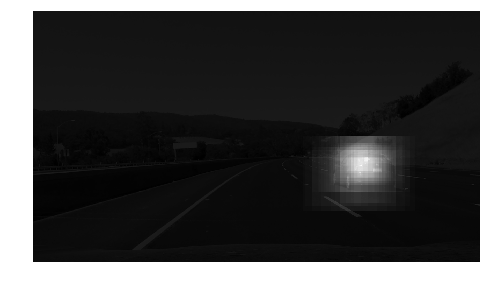

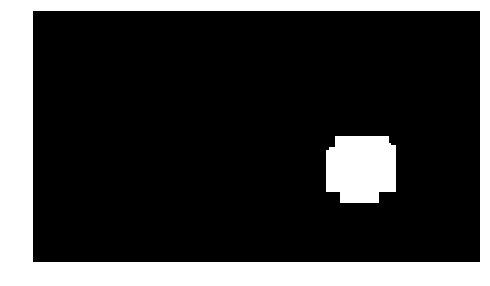

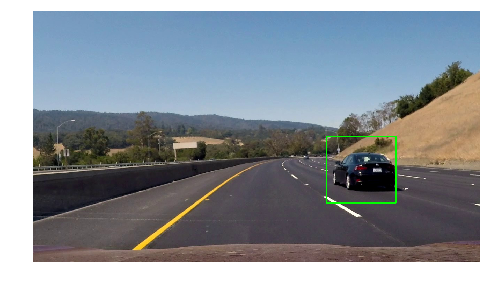

In [54]:
from scipy.ndimage.measurements import label

def draw_rectangle(img, p1, p2):
    return cv2.rectangle(img, p1, p2, (0,255,0), 2)

img = cv2.imread('./export3.jpg')

img_gray = convert_to_gray(img)
res = cv2.addWeighted(img_gray.astype('float64'), 0.8, heat_map, 20.0, 0)

plot_image(res)


heat_map_thresh = np.zeros_like(heat_map)
heat_map_thresh[heat_map >= 10] = 1

plot_image(heat_map_thresh)


labeled_array, num_features = label(heat_map_thresh)

for i in range(num_features):
    x_ind, y_ind = np.nonzero(labeled_array == i+1)
    #x_min = np.min(x_ind)
    #y_min = np.min(y_ind)
    #print(x_min, y_min)
    draw_rectangle(img, (np.min(y_ind), np.min(x_ind)), (np.max(y_ind), np.max(x_ind)))

plot_image(img)





In [ ]:


def filter_heat_map(heat_map, buffer_size = 5):    
    global heat_map_buffer    
    
    if ('heat_map_buffer' not in globals()) or (heat_map_buffer is None):
        heat_map_buffer = []

    if len(heat_map_buffer) < buffer_size:
        heat_map_buffer.append(heat_map)
    else:
        del heat_map_buffer[0]
        heat_map_buffer.append(heat_map)
        
    filtered_map = np.zeros_like(heat_map)
    
    for hm in heat_map_buffer:
        filtered_map += hm
        
    return filtered_map

def check_rect_intersect(rect1, rect2):
    if (rect1[2]<rect2[0] or rect2[2]<rect1[0] or rect1[3]<rect2[1] or rect2[3]<rect1[1]):
        return False
    else:
        return True
    
def low_pass_filter(new_val, old_val, filter_coeff):
    return (1.0-filter_coeff)*new_val + filter_coeff*old_val

def filter_rectangle(rect, rect_old):
    for i in range(4):
        rect[i] = int(low_pass_filter(rect[i], rect_old[i], 0.95)) #0.9
        
    return rect

def draw_vehicle_rects(img, heat_map, rect_list_old, heat_threshold = 55):
    
    heat_map_thresh = np.zeros_like(heat_map)
    heat_map_thresh[heat_map >= heat_threshold] = 1

    labeled_array, num_features = label(heat_map_thresh)
    
    rect_list = []

    for i in range(num_features):
        x_ind, y_ind = np.nonzero(labeled_array == i+1)
        
        rect = [np.min(y_ind), np.min(x_ind), np.max(y_ind), np.max(x_ind)]
        
        for rect_old in rect_list_old:
            if check_rect_intersect(rect, rect_old):
                rect = filter_rectangle(rect, rect_old)               
                
        rect_list.append(rect)        
        draw_rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]))
        
    return img, rect_list

# IDEA: for rectangle fitting -> use some weighted process using the heat instensity values



#start_frame = 800 # black car, white is behind
#start_frame = 740
start_frame = 950
num_frames = 120

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi',fourcc, 24.0, (img.shape[1],img.shape[0]))

vidcap = cv2.VideoCapture('project_video.mp4')
img_count = 0
heat_map = None
heat_map_buffer = None
rect_list = []
success, img = vidcap.read()

while success:      
  
    img_count += 1  

    if img_count > start_frame:
        print(img_count)
        
        #cv2.imwrite("export3.jpg", img)

        heat_map = calculate_heat_map(img)          
        heat_map_filtered = filter_heat_map(heat_map)  
        
        #img_gray = convert_to_gray(img)
        #res = cv2.addWeighted(img_gray.astype('float64'), 0.8, heat_map_filtered, 2.0, 0)
        #plot_image(res)    
             

        img_with_rects, rect_list = draw_vehicle_rects(img, heat_map_filtered, rect_list)
        
        #plot_image(img_with_rects)

        video.write(img_with_rects)
        
        
        
    if img_count >= start_frame + num_frames:
        break
        
    success, img = vidcap.read()
    
video.release() 
print('finished!')

951
952
953
954
955
956
957
958
959


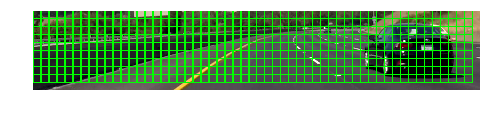

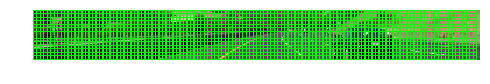

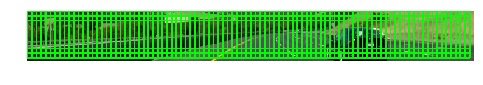

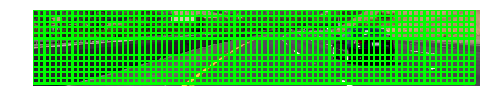

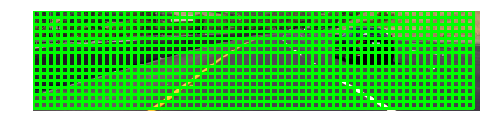

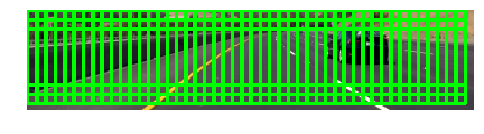

In [44]:

def plot_sub_images(img):
    for level in detection_levels:
        
        # resize the image according to the current detection level 
        img_resized = level.resize_image(img) 
    
        img_patches = get_patches(img_resized, level.stride)[0]        
        plot_image(draw_patches(img_resized, img_patches))


plot_sub_images(img)



In [ ]:
img = cv2.imread('./export.jpg')

img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) 

plot_image(img_conv[:,:,0]) # not much usage
plot_image(img_conv[:,:,1])
plot_image(img_conv[:,:,2], size=(12,8))

plot_image(convert_to_gray(img),  size=(12,8))

rimg=cv2.flip(img,1)
plot_image(rimg)

In [ ]:
img = cv2.imread('./training_data/vehicles/GTI_Far/image0000.png')

print(img)